# Basic Bayesian Linear Regression Implementation

In [39]:
# Pandas and numpy for data manipulation
import pymc3 as pm
import scipy
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import io
import warnings

# Matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# DOCUMENTACIÓN DE LA BIBLIOTECA PYMC3
# https://docs.pymc.io/en/v3/pymc-examples/examples/getting_started.html
# https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-linear.html

# SOBRE NUTS: https://arxiv.org/abs/1111.4246

# EJERCICIO BASADO EN EL SGTE ARTÍCULO:
# https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7

# OTRO LINK DE INTERÉS:
# https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-2-b72059a8ac7e

# Linear Regression to verify implementation
# Scipy for statistics
# PyMC3 for Bayesian Inference

warnings.filterwarnings('ignore')
print(f"Running on PyMC3 v{pm.__version__}")


Running on PyMC3 v3.11.5


# Cargar datos de ejercicio

In [40]:
url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/arbolado-en-espacios-verdes/arbolado-en-espacios-verdes.csv'
arb = requests.get(url).content
data_arbolado_parques = pd.read_csv(io.StringIO(arb.decode('utf-8')))

# columnas que me interesan
col_interes = ['diametro', 'altura_tot', 'nombre_com']
nombre = 'nombre_com'  # nombre común, no científico
nombres_interes = ['Jacarandá', 'Palo borracho rosado', 'Eucalipto', 'Ceibo']

# preparo los dataframe
# selecciono x columnas
data_diametro_altura = data_arbolado_parques[col_interes].copy()

# cambio nombre a 'altura'
data_diametro_altura.rename(columns={'altura_tot': 'altura'}, inplace=True)
diametro_altura_especies = data_diametro_altura[data_diametro_altura['nombre_com'].isin(
    nombres_interes)]

# me quedo con los jacarandás
jaca = diametro_altura_especies[diametro_altura_especies['nombre_com'] == 'Jacarandá']
jaca.reset_index(inplace=True)
jaca.head()
jaca.drop(['nombre_com', 'index'], axis=1, inplace=True)
jaca.tail()
# jaca.shape    # (3255, 2)


,diametro,altura
3250,97,7
3251,28,8
3252,30,2
3253,10,3
3254,40,17


# Relación de trama

In [44]:
# columnas
print(data_arbolado_parques.columns)

# Nombres de las especies
print(data_arbolado_parques['nombre_com'].unique())

# Cantidad de especies
print(data_arbolado_parques['nombre_com'].unique().size)

Index(['long', 'lat', 'id_arbol', 'altura_tot', 'diametro', 'inclinacio',
       'id_especie', 'nombre_com', 'nombre_cie', 'tipo_folla', 'espacio_ve',
       'ubicacion', 'nombre_fam', 'nombre_gen', 'origen', 'coord_x',
       'coord_y'],
      dtype='object')
['Washingtonia (Palmera washingtonia)' 'Ombú' 'Catalpa' 'Ceibo'
 'Brachichiton (Árbol botella, Brachichito)' 'Álamo plateado'
 'Acacia de constantinopla' 'Acacia' 'Roble sedoso (Grevillea)' 'Arce'
 'Palo borracho rosado' 'Álamo negro del Canada' 'Jacarandá'
 'Álamo carolina' 'Aguaribay' 'Paraíso' 'Espinillo (Aromo)' 'Eucalipto'
 'Ciprés leylandi' 'Ciprés' 'No Determinable' 'Álamo' 'No Determinado'
 'Cedro' 'Lapacho' 'Crataegus' 'Cedro de San Juan' 'Juniperus'
 'Chamaecyparis' 'Álamo blanco piramidal' 'Podocarpus' 'Tuja' 'El chañar'
 'Arce tridente' 'Citricos' 'Sauce' 'Viburnum dulce' 'Corona de cristo'
 'Taxodium' 'Mirto' 'Árbol del humo' 'Celtis tala'
 'Criptomeria (Cedro del Japón)' 'Coculus, Cóculo' 'Caoba del sur'
 'Arce blan

In [41]:
data_arbolado_parques

,long,lat,id_arbol,altura_tot,diametro,inclinacio,id_especie,nombre_com,nombre_cie,tipo_folla,espacio_ve,ubicacion,nombre_fam,nombre_gen,origen,coord_x,coord_y
0,-58.477564,-34.645015,1,6,35,0,53,Washingtonia (Palmera washingtonia),Washingtonia filifera,Palmera,"AVELLANEDA, NICOLÁS, Pres.","DIRECTORIO, AV. - LACARRA, AV. - MONTE - AUTO...",Arecaceas,Washingtonia,Exótico,98692.305719,98253.300738
1,-58.477559,-34.645047,2,6,35,0,53,Washingtonia (Palmera washingtonia),Washingtonia filifera,Palmera,"AVELLANEDA, NICOLÁS, Pres.","DIRECTORIO, AV. - LACARRA, AV. - MONTE - AUTO...",Arecaceas,Washingtonia,Exótico,98692.751564,98249.733979
2,-58.477551,-34.645091,3,6,35,0,53,Washingtonia (Palmera washingtonia),Washingtonia filifera,Palmera,"AVELLANEDA, NICOLÁS, Pres.","DIRECTORIO, AV. - LACARRA, AV. - MONTE - AUTO...",Arecaceas,Washingtonia,Exótico,98693.494639,98244.829684
3,-58.478129,-34.644567,4,17,50,0,65,Ombú,Phytolacca dioica,Árbol Latifoliado Caducifolio,"AVELLANEDA, NICOLÁS, Pres.","DIRECTORIO, AV. - LACARRA, AV. - MONTE - AUTO...",Fitolacáceas,Phytolacca,Nativo/Autóctono,98640.439091,98302.938142
4,-58.478121,-34.644598,5,17,50,0,65,Ombú,Phytolacca dioica,Árbol Latifoliado Caducifolio,"AVELLANEDA, NICOLÁS, Pres.","DIRECTORIO, AV. - LACARRA, AV. - MONTE - AUTO...",Fitolacáceas,Phytolacca,Nativo/Autóctono,98641.182166,98299.519997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51497,-58.505752,-34.562998,51725,15,30,0,45,Casuarina,Casuarina cunninghamiana,Árbol Latifoliado Perenne,GENERAL PAZ,"LARRALDE, CRISOLOGO, AV. - PAZ, GRAL., AV.- AI...",Casuarinaceas,Casuarina,Exótico,96104.125550,107350.962385
51498,-58.507111,-34.565843,51726,13,31,0,45,Casuarina,Casuarina cunninghamiana,Árbol Latifoliado Perenne,GENERAL PAZ,"LARRALDE, CRISOLOGO, AV. - PAZ, GRAL., AV.- AI...",Casuarinaceas,Casuarina,Exótico,95979.513368,107035.237268
51499,-58.475721,-34.565192,51727,11,28,0,17,Árbol del cielo (Ailanto o Árbol de los dioses),Ailanthus altissima,Árbol Latifoliado Caducifolio,"CAMPELO, LICENCIADO CARLOS",ESTACIÓN COGHLAN - Propiedad particular e/UGAR...,Simarrubáceas,Ailanthus,Exótico,98860.090864,107108.347622
51500,-58.507026,-34.565670,51728,5,32,0,342,Ciprés,Cupressus sp.,Árbol Conífero Perenne,GENERAL PAZ,"LARRALDE, CRISOLOGO, AV. - PAZ, GRAL., AV.- AI...",Cupresáceas,Cupressus,Exótico,95987.288841,107054.471332


In [46]:
jaca

,diametro,altura
0,10,5
1,10,5
2,10,5
3,10,5
4,10,5
...,...,...
3250,97,7
3251,28,8
3252,30,2
3253,10,3


Text(0.5, 1.0, 'Jacarandás: Altura vs. Diámetro')

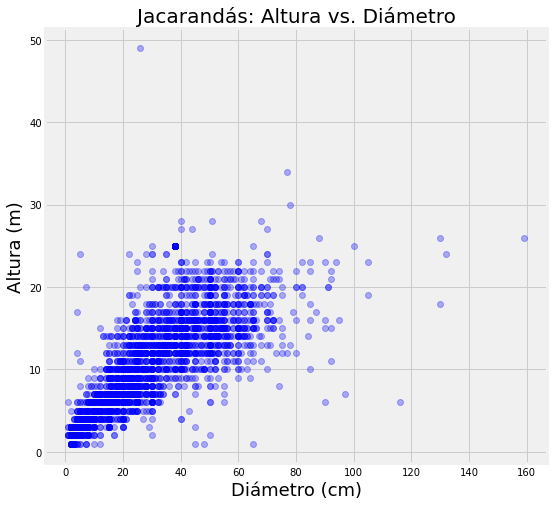

In [45]:
plt.figure(figsize=(8, 8))

# Establecemos el eje X = jaca['diametro'] | Y = jaca['altura']
plt.plot(jaca['diametro'], jaca['altura'], 'bo', alpha=0.3)

# Titulo del eje X
plt.xlabel('Diámetro (cm)', size=18)
# Titulo del eje Y
plt.ylabel('Altura (m)', size=18)

# Titulo
plt.title('Jacarandás: Altura vs. Diámetro', size=20)

In [47]:
# Crear las características y la respuesta.
X = jaca.loc[:, ['diametro']]
y = jaca.loc[:, 'altura']


# Implementar la regresión lineal de mínimos cuadrados ordinarios a mano

In [48]:
def ajuste_lineal_simple(x, y):
    ''' Dados dos np.array 'x' e 'y', calcula por el método de mínimos cuadrados
    el ajuste lineal para los np.array dados. Los coeficientes son retornados 
    en una tupla (pendiente,ordenada al origen).'''
    a = sum(((x - x.mean())*(y-y.mean()))) / sum(((x-x.mean())**2))
    b = y.mean() - a*x.mean()

    return a, b


Ejecutar la implementación a mano

In [49]:
# Convertir las columnas en array
xs = jaca[['diametro']].to_numpy()
ys = jaca[['altura']].to_numpy()

#Toma mos nuestros coeficientes
by_hand_coefs = ajuste_lineal_simple(xs, ys)


print('ordenade del origen calculada a mano:', by_hand_coefs[1])
print('Pendiente calculada a mano: ', by_hand_coefs[0])


Intercept calculated by hand: [3.5757255]
Slope calculated by hand:  [0.23586268]


Text(0.5, 1.0, 'Altura vs Diámetro Jacarandás')

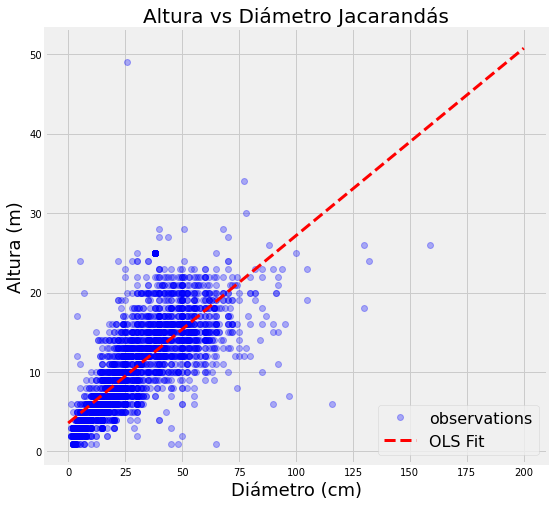

In [50]:
# Datos linealizados
xss = np.linspace(0, 200, 1000)

#Coeficientes del la regresion lineal manual
yss = by_hand_coefs[1] + by_hand_coefs[0] * xss

# Plano del grafico
plt.figure(figsize=(8, 8))
# Putnos de datos
plt.plot(jaca['diametro'], jaca['altura'],
         'bo', label='observations', alpha=0.3)
# Ttulo eje X
plt.xlabel('Diámetro (cm)', size=18)

# Titulo eje Y
plt.ylabel('Altura (m)', size=18)

# Grafico de regresión manual
plt.plot(xss, yss, 'r--', label='OLS Fit', linewidth=3)
plt.legend(prop={'size': 16})
# Ttitulo
plt.title('Altura vs Diámetro Jacarandás', size=20)


## Prediction for Datapoint

In [51]:
print(f'Altura estimada para un diámetro de 100 cm: {by_hand_coefs[1] + by_hand_coefs[0] * 100}')

Altura estimada para un diámetro de 100 cm: [27.16199386]


# Verificar con la implementación de Scikit-learn

In [52]:
# Crear el modelo(de SKlearn) y ajustarlo a los datos.
lr = LinearRegression()
lr.fit(X['diametro'].to_frame(), y)

print('Ordenada del origen de Sklearn', lr.intercept_)
print('Pendiente de Sklearn:', lr.coef_[0])

Intercept from library: 3.575725504521383
Slope from library: 0.2358626835340227


podemos ver que precticamente no hay diferencia con el modelo manual

# Regresión lineal bayesiana

### PyMC para inferencia bayesiana

Implemente MCMC para encontrar la distribución posterior de los parámetros del modelo. En lugar de una estimación de un solo punto de los pesos del modelo, la regresión lineal bayesiana nos dará una distribución posterior para los pesos del modelo.

## Modelo con 100 Observaciones

In [53]:
# MCMC es un algoritmo Markov Chain Montecarlo
with pm.Model():
    # PRIMERO DEFINE LOS PRIORS, ES DECIR, LO SUPUESTO A PRIORI
    
    # Intercept = Ordenada del origen
    # Con pm.Normal le deciemos cree una distrubución normal
    intercept = pm.Normal('Intercept', mu=0, sigma=1)

    # Slope = Pendienete
    # Con pm.Normal le deciemos cree una distrubución normal
    slope = pm.Normal('slope', mu=0, sigma=1)

    # sigma = Desviacion estandar
    # Modelo con todas las observaciones
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Estimación de la media
    mean = intercept + slope * X.loc[0:99, 'diametro']

    # Observed values, DEBE SER DATAFRAME
    """Aqui hacemos un modelo pequeño de pueva 
    solo usamos las primeras 100 muestras en "observed"
    """
    Y_obs = pm.Normal('Y_obs', mu=mean, sigma=sigma, observed=y.values[0:100])

    # Sampler: NUTS define los pasos que hacen converger al descenso del gradiente
    step = pm.NUTS()   # SE USA NUTS PARA VARIABLES CONTINUAS

    # Posterior distribution: DIBUJA 2MIL MUESTRAS USANDO NUTS SAMPLER
    parcial = pm.sample(2000, step)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 17 seconds.


## Modelo con todas las observaciones

In [54]:
with pm.Model() as lm:
    # Intercept = Ordenada del origen
    # Con pm.Normal le deciemos cree una distrubución normal
    intercept = pm.Normal('Intercept', mu=0, sd=1)

    # Slope = Pendienete
    # Con pm.Normal le deciemos cree una distrubución normal
    slope = pm.Normal('slope', mu=0, sd=1)

    # sigma = Desviacion estandar
    sigma = pm.HalfNormal('sigma', sd=1)

    # Estimate of mean for likelihood
    mean = intercept + slope * X.loc[:, 'diametro']

    # Usamos todas las observaciones / datos
    Y_obs = pm.Normal('Y_obs', mu=mean, sigma=sigma, observed=y.values)

    # Reduciomes el gradiente
    step = pm.NUTS()

    # Posterior distribution
    full = pm.sample(4000, step)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, Intercept]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 34 seconds.


ALTERNATIVA PARA INSTANCIAR MODELOS
Queda una sintaxis super compacta :)

In [12]:
import arviz as az
import bambi as bmb

model = bmb.Model('altura ~ diametro', jaca)
predictor = model.fit(draws=2000)


ModuleNotFoundError: No module named 'bambi'

# Resultados del modelo bayesiano

El modelo bayesiano ofrece más oportunidades de interpretación que la regresión de mínimos cuadrados ordinarios porque proporciona una distribución posterior. Podemos usar esta distribución para encontrar el valor único más probable, así como el rango completo de valores probables para los parámetros de nuestro modelo.

PyMC3 tiene muchas herramientas integradas para visualizar e inspeccionar ejecuciones de modelos. Estos nos permiten ver las distribuciones y proporcionar estimaciones con un nivel de incertidumbre, que debería ser una parte necesaria de cualquier modelo.

## Trace of All Model Parameters

LAS DOS LÍNEAS QUE SE VEN CORRESPONDEN A LAS CADENAS QUE USA NUTS PARA SAMPLEAR
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) 

El grafico de la izquierda es la distribución que toman los datos de la ordenada del origen, la pendiente, la desviacion estandar (linea) y los pasao para samplear de nuts (linea de puntos)

Al lado podemos ver los residuos de la distribucion

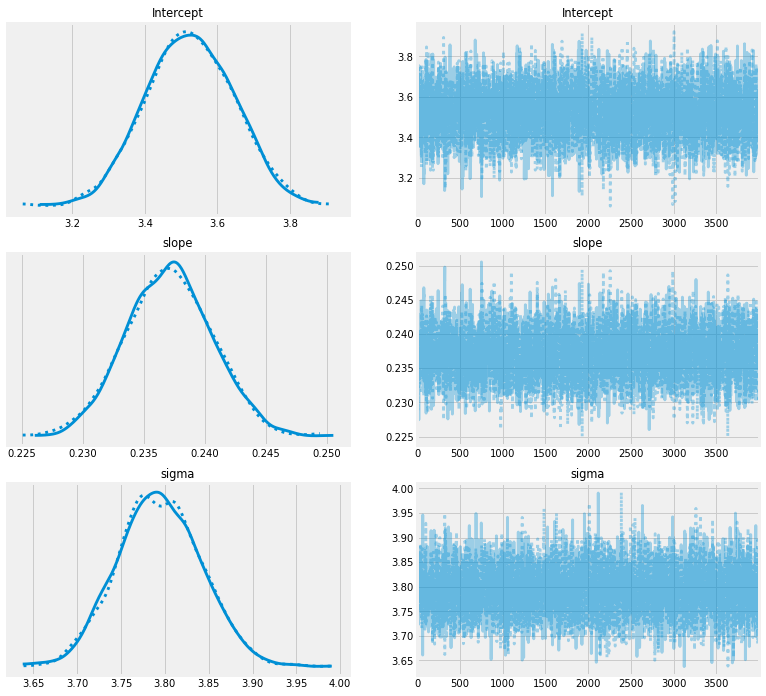

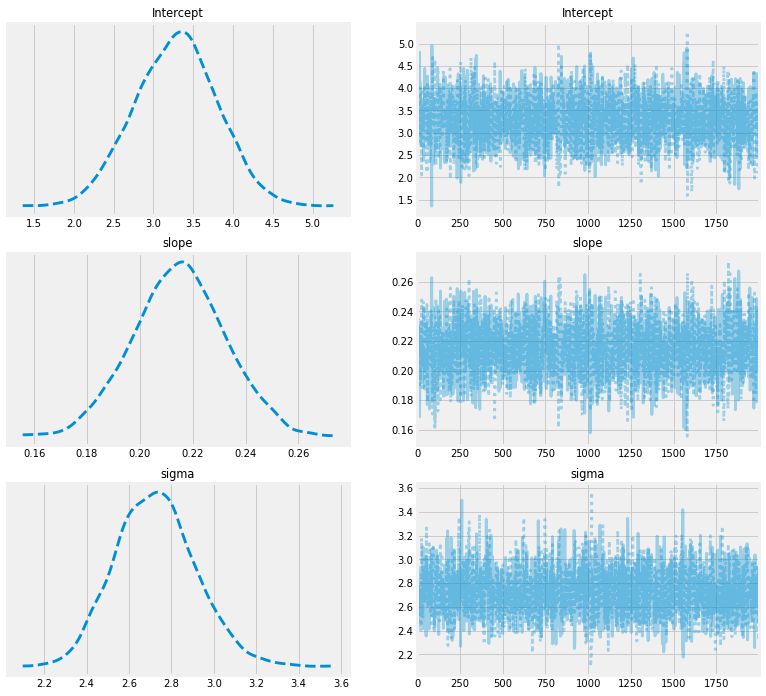

In [55]:
with pm.Model() as lm: 
    pm.plot_trace(full, figsize=(12, 12))
    pm.plot_trace(parcial, figsize=(12, 12), combined=True)


## Distribución posterior de los parámetros del modelo

La intrepretación del grafico seria la siguiente:
- Los valores extremos de cada distribucion son los valores minimos y maximos
- Lo que esta en el medio (sobre la ralla negra) son los valores esperados con un nivel de confianza del 94%
- "Mean" se refiere al valor medio más de cada parametro (con un 94% de confianza)

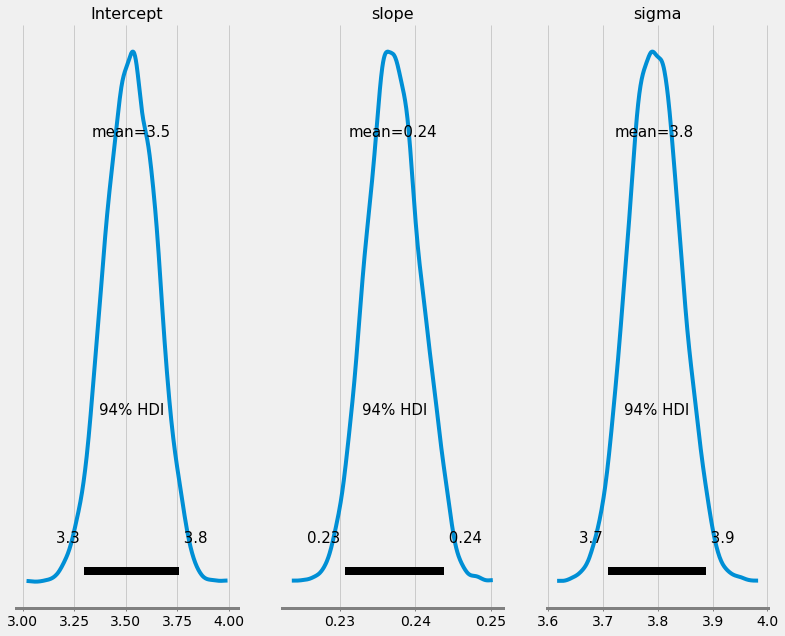

In [29]:
with pm.Model() as lm:
    pm.plot_posterior(full, figsize=(12, 10))


## Intervalos de confianza para los parámetros del modelo

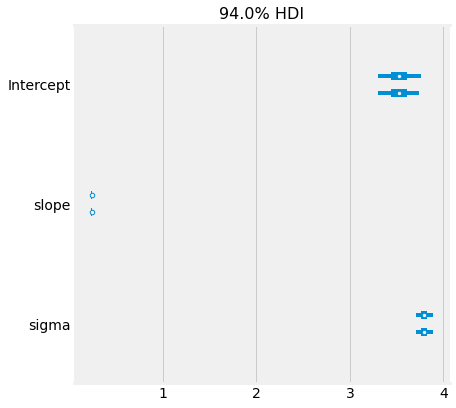

In [56]:
with pm.Model() as lm:
    pm.plot_forest(full)


# Predicciones de respuesta muestreadas del posterior

Ahora podemos generar predicciones de la línea de regresión lineal utilizando los resultados del modelo. El siguiente gráfico muestra 1000 estimaciones diferentes de la línea de regresión dibujada desde la parte posterior. La distribución de las líneas da una estimación de la incertidumbre en la estimación. La regresión lineal bayesiana tiene la ventaja de que nos brinda una __distribución__ posterior en lugar de una __estimación de un solo punto__ en la regresión frecuentista de mínimos cuadrados ordinarios.

## Todas las observaciones

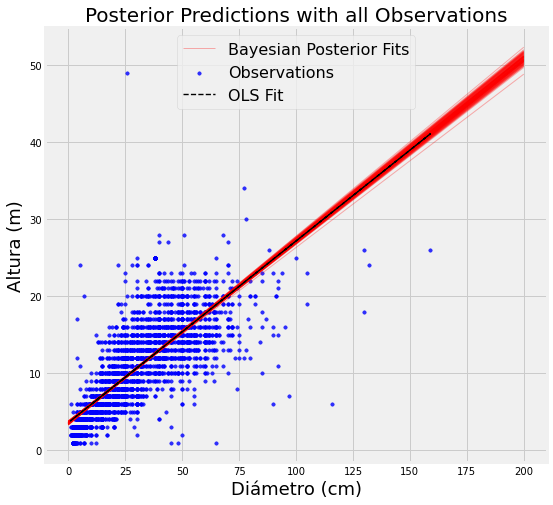

In [57]:
plt.figure(figsize=(8, 8))

# Graficamos los resutados de nuestras posibles regresiones lineales 
# Cada una con diferentes coeficientes
pm.plot_posterior_predictive_glm(full, samples=100, eval=np.linspace(0, 200, 1000), linewidth=1,
                                 color='red', alpha=0.3, label='Bayesian Posterior Fits',
                                 lm=lambda x, sample: sample['Intercept'] + sample['slope'] * x)
# Graficamos los datos
plt.scatter(X['diametro'], y.values, s=12, alpha=0.8,
            c='blue', label='Observations')

# Graficamos el resultado de nuestra primera regresion lineal a mano 
plt.plot(X['diametro'], by_hand_coefs[1] + X['diametro'] *
         by_hand_coefs[0], 'k--', label='OLS Fit', linewidth=1.4)

#Titulo
plt.title('Posterior Predictions with all Observations', size=20)

#Titulos eje X
plt.xlabel('Diámetro (cm)', size=18)
#Titulo eje Y
plt.ylabel('Altura (m)', size=18)

plt.legend(prop={'size': 16})

con **pm.summary** podemos ver informacion referente a los parametros generados por nuestra regresion bayesiana.
La interpretación seria la seguiente:
- **mean:** Valor medio
- **sd:** Desviación estándar de la distribución posterior del parámetro.
- **hdi_3%:** Valores con un 3% de probabilidad
- **hdi_97%:** Valores con un 97% de probabilidad
- **mcse_mean:** el error estándar de Monte Carlo para la media del parámetro.
- **mcse_sd:** el error estándar de Monte Carlo para la desviación estándar del parámetro.
- **ess_bulk:** el ESS calculado sobre el 80% central de las muestras.
- **r_hat:** el valor R-hat, una medida de convergencia del algoritmo de muestreo de Markov Chain Monte Carlo (MCMC).
- **ess_tail:** el ESS calculado sobre el 20% de las muestras de las colas.

In [34]:
with pm.Model() as lm:
    summ = pm.summary(full)
print(summ)

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  3.525  0.124   3.299    3.760      0.002    0.001    4163.0   
slope      0.237  0.004   0.231    0.244      0.000    0.000    4269.0   
sigma      3.794  0.048   3.708    3.887      0.001    0.001    4352.0   

           ess_tail  r_hat  
Intercept    4457.0    1.0  
slope        4230.0    1.0  
sigma        4302.0    1.0  


## Limited Observations

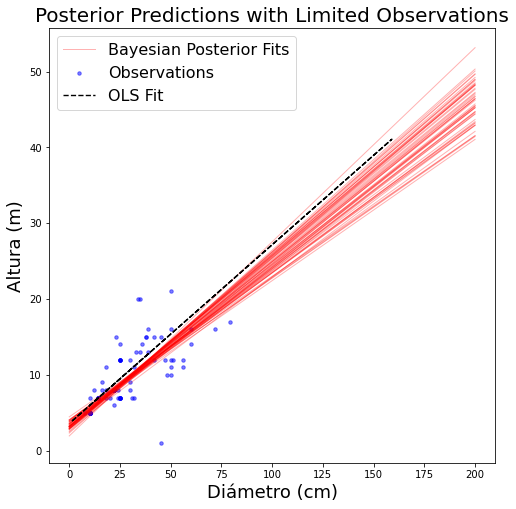

In [19]:
plt.figure(figsize=(8, 8))

# Graficamos los resutados de nuestras posibles regresiones lineales(esta vez solo con 50 muestras) 
# Cada una con diferentes coeficientes
pm.plot_posterior_predictive_glm(parcial, samples=50, eval=np.linspace(0, 200, 1000), linewidth=1,
                                 color='red', alpha=0.3, label='Bayesian Posterior Fits',
                                 lm=lambda x, sample: sample['Intercept'] + sample['slope'] * x)

# Graficamos los datos
plt.scatter(X['diametro'][:100], y.values[:100], s=12,
            alpha=0.5, c='blue', label='Observations')

# Graficamos el resultado de nuestra primera regresion lineal a mano 
plt.plot(X['diametro'], by_hand_coefs[1] + X['diametro'] *
         by_hand_coefs[0], 'k--', label='OLS Fit', linewidth=1.4)

#Titulo
plt.title('Posterior Predictions with Limited Observations', size=20)
#Titulo eje X
plt.xlabel('Diámetro (cm)', size=18)
#Titulo eje Y
plt.ylabel('Altura (m)', size=18)

plt.legend(prop={'size': 16})

In [35]:
with pm.Model() as lm:
    parc=pm.summary(parcial)
print(parc)

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  3.302  0.483   2.398    4.171      0.013    0.009    1448.0   
slope      0.214  0.016   0.184    0.244      0.000    0.000    1562.0   
sigma      2.720  0.194   2.369    3.091      0.005    0.003    1707.0   

           ess_tail  r_hat  
Intercept    2017.0    1.0  
slope        1379.0    1.0  
sigma        1340.0    1.0  


# Specific Prediction for One Datapoint

In [36]:
bayes_prediction = parcial['Intercept'] + parcial['slope'] * 100
print(type(bayes_prediction))     # numpy.ndarray
print(bayes_prediction.shape)


<class 'numpy.ndarray'>
(4000,)


Text(0.5, 1.0, 'Predicción posterior para 100 cm de diámetro')

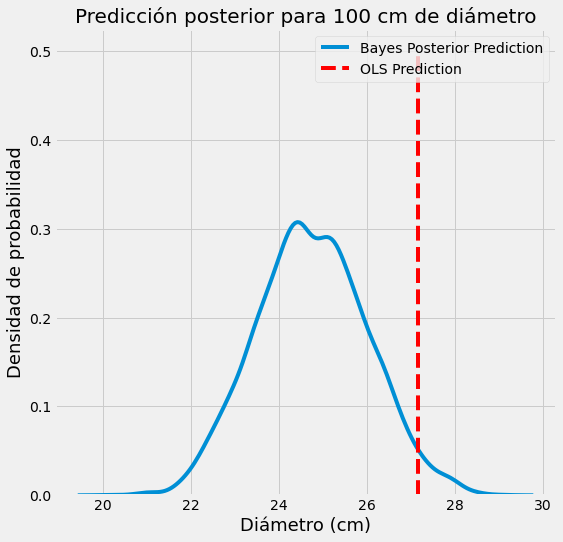

In [37]:
plt.figure(figsize=(8, 8))
# Estilo de grafico
plt.style.use('fivethirtyeight')

# Graficamos la distribución de nuestros datos.
sns.kdeplot(bayes_prediction, label='Bayes Posterior Prediction')

# Predicción del modelo usando solo los datos parciales(100 muestras)
plt.vlines(x=by_hand_coefs[1] + by_hand_coefs[0] * 100,
           ymin=0, ymax=.5,
           label='OLS Prediction',
           colors='red', linestyles='--')

plt.legend()
# Titulo eje X
plt.xlabel('Diámetro (cm)', size=18), plt.ylabel(
            'Densidad de probabilidad', size=18)
# Titulo
plt.title('Predicción posterior para 100 cm de diámetro', size=20)

PREDICCIÓN PARA UN PUNTO USANDO EL MODELO COMPLETO

In [25]:
inter = full['Intercept']
pend = full['slope']
pred_full = inter + pend * 100
inter.shape

(8000,)

Text(0.5, 1.0, 'Predicción posterior para 100 cm de diámetro (Modelo completo)')

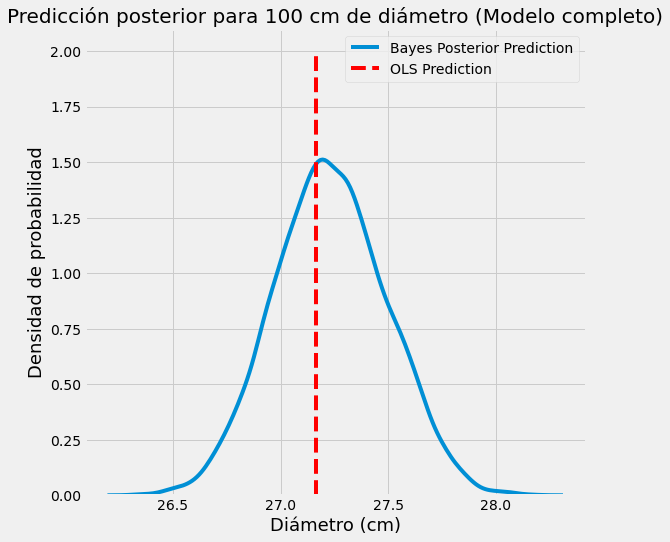

In [26]:
plt.figure(figsize=(8, 8))

# Estilo de grafico
plt.style.use('fivethirtyeight')

# Graficamos la distribución de nuestros datos.
sns.kdeplot(pred_full, label='Bayes Posterior Prediction')

# Predicción del modelo usando solo los datos Totales
plt.vlines(x=by_hand_coefs[1] + by_hand_coefs[0] * 100,
           ymin=0, ymax=2.,
           label='OLS Prediction',
           colors='red', linestyles='--')
plt.legend()

# Titulo eje X
plt.xlabel('Diámetro (cm)', size=18), plt.ylabel(
    'Densidad de probabilidad', size=18)
# Titulo
plt.title('Predicción posterior para 100 cm de diámetro (Modelo completo)', size=20)